In [1]:
import pathlib
import os
import warnings
warnings.filterwarnings('ignore')

# Change to the project root directory
project_root = pathlib.Path("/Users/victormp/Desktop/ml/ml-project")
os.chdir(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from darts.models import ARIMA
from darts import TimeSeries
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA as Arima
import torch
import torch.nn as nn
#from torch.nn.utils import weight_norm
#from src.models import AdditiveHybrid_AR_TCN
#from src.models import Classic_TCN
from src.train import train_tcn_model
from src.train import train_additive_model
import random


# Import Data

In [2]:
data_path = pathlib.Path("data/DCOILWTICO.csv")
print(f"Loading from: {data_path.absolute()}")
print(f"File exists: {data_path.exists()}")

data = pd.read_csv(data_path)
data.rename(columns = {"observation_date" : "date", "DCOILWTICO" : "price"}, inplace  = True)
data["date"] = pd.to_datetime(data["date"])
data = data.set_index("date")
data["return"] = np.log(data["price"]) - np.log(data["price"].shift(1))
returns = data["return"].replace([np.inf, -np.inf], np.nan).dropna().astype("float32")

Loading from: /Users/victormp/Desktop/ml/ml-project/data/DCOILWTICO.csv
File exists: True


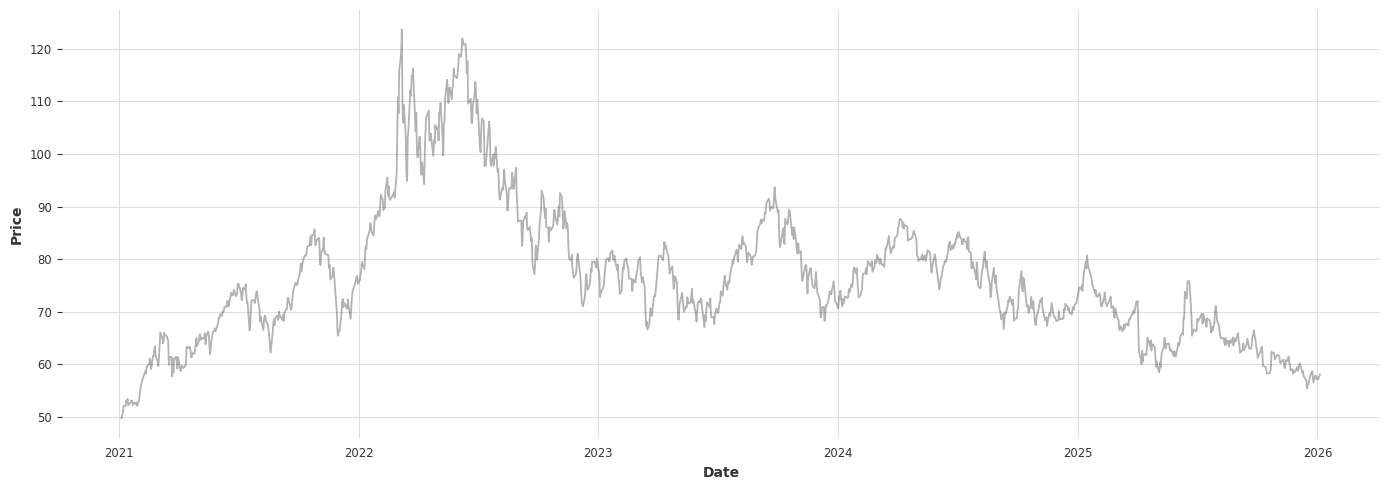

In [3]:
plt.figure(figsize=(14, 5))
sns.lineplot(x = data.index, y = data["price"], alpha=0.3)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()

# Split Data

In [4]:
split_point = int(len(returns) * 0.8)  # 80% train, 20% test
y_train = returns.iloc[:split_point]
y_test = returns.iloc[split_point:]

# Convert y_train["return"] and y_test["return"] to darts TimeSeries objects
train_series = TimeSeries.from_values(y_train)
test_series = TimeSeries.from_values(y_test)

# AR Model Selection

In [5]:
returns = y_train
print("="*60)
print("AR vs ARMA MODEL COMPARISON")
print("="*60)
print(f"Sample size: {len(returns)}\n")

# Test different combinations
results = []
print(f"{'Model':<15} {'AIC':<12} {'BIC':<12} {'Log-Lik':<12}")
print("-"*60)

#Pure AR models
for p in range(1, 6):
    try:
        model = Arima(returns, order=(p, 0, 0)).fit()
        results.append({
            'model': f'AR({p})',
            'p': p, 'q': 0,
            'aic': model.aic,
            'bic': model.bic,
            'llf': model.llf
        })
        print(f"AR({p}){'':<10} {model.aic:<12.2f} {model.bic:<12.2f} {model.llf:<12.2f}")
    except Exception as e:
        print(f"AR({p}) FAILED: {e}")
        continue

print()

#ARMA models
for p in range(1, 4):
    for q in range(1, 4):
        try:
            model = Arima(returns, order=(p, 0, q)).fit()
            results.append({
                'model': f'ARMA({p},{q})',
                'p': p, 'q': q,
                'aic': model.aic,
                'bic': model.bic,
                'llf': model.llf
            })
            print(f"ARMA({p},{q}){'':<8} {model.aic:<12.2f} {model.bic:<12.2f} {model.llf:<12.2f}")
        except Exception as e:
            print(f"ARMA({p},{q}) FAILED: {e}")
            continue

if len(results) == 0:
    print("\nERROR: No models could be fitted!")
    raise ValueError("Cannot proceed - no models were fitted successfully")

#find best models
results_df = pd.DataFrame(results)
best_aic_idx = results_df['aic'].idxmin()
best_bic_idx = results_df['bic'].idxmin()
best_aic_model = results_df.loc[best_aic_idx, 'model']
best_bic_model = results_df.loc[best_bic_idx, 'model']

print("\n" + "="*60)
print("BEST MODELS:")
print(f"  By AIC: {best_aic_model:<12} (AIC = {results_df.loc[best_aic_idx, 'aic']:.2f})")
print(f"  By BIC: {best_bic_model:<12} (BIC = {results_df.loc[best_bic_idx, 'bic']:.2f})")
print("="*60)

#Check if ARMA is better
best_ar_bic = results_df[results_df['q'] == 0]['bic'].min()
best_arma_bic = results_df[results_df['q'] > 0]['bic'].min()

print("\nCONCLUSION:")
if best_arma_bic < best_ar_bic:
    improvement = best_ar_bic - best_arma_bic
    print(f"  ARMA fits better than pure AR")
    print(f"  BIC improvement: {improvement:.2f}")
    print(f"  Best model: {best_bic_model}")
else:
    print(f"  Pure AR is sufficient")
    best_ar_idx = results_df[results_df['q']==0]['bic'].idxmin()
    print(f"  Best model: {results_df.loc[best_ar_idx, 'model']}")
print("="*60)

# Fit and diagnose best model
print(f"\nFitting best model: {best_bic_model}")

# Extract p and q properly
best_p = int(results_df.loc[best_bic_idx, 'p'])
best_q = int(results_df.loc[best_bic_idx, 'q'])

# Now fit the model
final_model = Arima(returns, order=(best_p, 0, best_q)).fit()
print("\nParameter Estimates:")
print(final_model.summary().tables[1])

# Check residuals
residuals = final_model.resid
lb_test = acorr_ljungbox(residuals, lags=[5, 10], return_df=True)
print("\nResidual Diagnostics (Ljung-Box):")
print(lb_test[['lb_stat', 'lb_pvalue']])

if (lb_test['lb_pvalue'] > 0.05).all():
    print("\n Residuals are white noise (model is adequate)")
else:
    print("\n Some autocorrelation remains in residuals")


#Extended Ljung-Box test with 20 lags for autocorrelation
print("\n" + "="*60)
print("Extended Ljung-Box test")
print("="*60)

lb_extended = acorr_ljungbox(residuals, lags=range(1, 21), return_df=True)
print("\nLjung-Box Test Results (lags 1-20):")
print(lb_extended[['lb_stat', 'lb_pvalue']])

# Summary
significant_lags = lb_extended[lb_extended['lb_pvalue'] < 0.05]
if len(significant_lags) == 0:
    print("\n Residuals pass Ljung-Box test at all lags")
else:
    print(f"\n Autocorrelation detected at {len(significant_lags)} lag(s):")
    print(f"  Lags: {list(significant_lags.index)}")


AR vs ARMA MODEL COMPARISON
Sample size: 954

Model           AIC          BIC          Log-Lik     
------------------------------------------------------------
AR(1)           -4493.86     -4479.28     2249.93     
AR(2)           -4496.04     -4476.60     2252.02     
AR(3)           -4496.19     -4471.88     2253.09     
AR(4)           -4495.12     -4465.96     2253.56     
AR(5)           -4504.09     -4470.06     2259.04     

ARMA(1,1)         -4491.73     -4472.29     2249.87     
ARMA(1,2)         -4492.09     -4467.79     2251.05     
ARMA(1,3)         -4496.05     -4466.89     2254.03     
ARMA(2,1)         -4500.96     -4476.66     2255.48     
ARMA(2,2)         -4497.47     -4468.30     2254.73     
ARMA(2,3)         -4498.50     -4464.48     2256.25     
ARMA(3,1)         -4494.21     -4465.04     2253.10     
ARMA(3,2)         -4493.01     -4458.98     2253.50     
ARMA(3,3)         -4496.40     -4457.52     2256.20     

BEST MODELS:
  By AIC: AR(5)        (AIC = -4504

# Train AR Model
### Calculate residuals, preditions on training set, and the MSE

In [6]:
#Flexible AR model
AR_ORDERS = [1, 5]

# Dictionary to store results
ar_results = {}

for ar_order in AR_ORDERS:
    print("="*60)
    print(f"FITTING AR({ar_order}) MODEL")
    print("="*60)

    # Train model and calculate residuals, compute MSE
    model = ARIMA(p=ar_order, d=0, q=0)
    model.fit(train_series)
    residuals = model.residuals(train_series)
    train_series_predict = model.predict(len(train_series))

    # To avoid nan, only compute MSE on pairs where both are not nan
    pred_vals = train_series_predict.values().flatten()
    true_vals = train_series.values().flatten()

    # Remove pairs where either is nan
    mask = ~np.isnan(pred_vals) & ~np.isnan(true_vals)
    mse = np.mean((true_vals[mask] - pred_vals[mask]) ** 2)
    mae = np.mean(np.absolute(true_vals[mask] - pred_vals[mask]))

    print(f"AR({ar_order}) MSE on training data: {mse:.6f}")
    print(f"AR({ar_order}) MAE on training data: {mae:.6f}")

    # Store results for later use
    ar_results[ar_order] = {
        'model': model,
        'residuals': residuals,
        'predictions': train_series_predict,
        'mse': mse, 
        'mae': mae, 
    }
    print()


FITTING AR(1) MODEL
AR(1) MSE on training data: 0.000524
AR(1) MAE on training data: 0.017440

FITTING AR(5) MODEL
AR(5) MSE on training data: 0.000524
AR(5) MAE on training data: 0.017445



In [7]:
# Summary table
print("="*60)
print("SUMMARY OF AR MODELS")
print("="*60)
print(f"{'Model':<15} {'MSE':<18} {'MAE'}")
print("-"*60)
for ar_order in AR_ORDERS:
    print(f"AR({ar_order}){'':<10} {ar_results[ar_order]['mse']:.6f}{'':<10} {ar_results[ar_order]['mae']:.6f}")
print("="*60)

SUMMARY OF AR MODELS
Model           MSE                MAE
------------------------------------------------------------
AR(1)           0.000524           0.017440
AR(5)           0.000524           0.017445


# Train TCN

In [8]:
print("=" * 60)
print("Training Classic TCN")
print("=" * 60)
model_classic_tcn = train_tcn_model(y_train.values, num_epochs=150)

Training Classic TCN
Classic TCN - Epoch [10/150], Loss: 0.000770
Classic TCN - Epoch [20/150], Loss: 0.000646
Classic TCN - Epoch [30/150], Loss: 0.000639
Classic TCN - Epoch [40/150], Loss: 0.000622
Classic TCN - Epoch [50/150], Loss: 0.000600
Classic TCN - Epoch [60/150], Loss: 0.000633
Classic TCN - Epoch [70/150], Loss: 0.000617
Classic TCN - Epoch [80/150], Loss: 0.000585
Classic TCN - Epoch [90/150], Loss: 0.000587
Classic TCN - Epoch [100/150], Loss: 0.000605
Classic TCN - Epoch [110/150], Loss: 0.000569
Classic TCN - Epoch [120/150], Loss: 0.000579
Classic TCN - Epoch [130/150], Loss: 0.000560
Classic TCN - Epoch [140/150], Loss: 0.000561
Classic TCN - Epoch [150/150], Loss: 0.000557


# Train Hybrid AR-TCN

In [9]:
#Loop to train the AR model to be flexible
AR_ORDERS = [1, 5]  # Train both AR(1)+TCN and AR(5)+TCN

hybrid_results = {}

for ar_order in AR_ORDERS:
    print("="*60)
    print(f"TRAINING ADDITIVE HYBRID AR({ar_order})+TCN MODEL")
    print("="*60)

    # Train the model
    model = train_additive_model(y_train, ar_order=ar_order, num_epochs=100, lr=0.001)

    # Store the model
    hybrid_results[ar_order] = {
        'model': model,
    }

    print(f"\n AR({ar_order}) + TCN model trained successfully\n")

# Summary
print("="*60)
print("HYBRID MODELS TRAINED")
print("="*60)
for ar_order in AR_ORDERS:
    print(f" AR({ar_order}) + TCN model available in hybrid_results[{ar_order}]")
print("="*60)

TRAINING ADDITIVE HYBRID AR(1)+TCN MODEL
Additive Hybrid AR(1) + TCN - Epoch [10/100], Loss: 0.000691
Additive Hybrid AR(1) + TCN - Epoch [20/100], Loss: 0.000626
Additive Hybrid AR(1) + TCN - Epoch [30/100], Loss: 0.000600
Additive Hybrid AR(1) + TCN - Epoch [40/100], Loss: 0.000586
Additive Hybrid AR(1) + TCN - Epoch [50/100], Loss: 0.000568
Additive Hybrid AR(1) + TCN - Epoch [60/100], Loss: 0.000559
Additive Hybrid AR(1) + TCN - Epoch [70/100], Loss: 0.000543
Additive Hybrid AR(1) + TCN - Epoch [80/100], Loss: 0.000543
Additive Hybrid AR(1) + TCN - Epoch [90/100], Loss: 0.000521
Additive Hybrid AR(1) + TCN - Epoch [100/100], Loss: 0.000505

 AR(1) + TCN model trained successfully

TRAINING ADDITIVE HYBRID AR(5)+TCN MODEL
Additive Hybrid AR(5) + TCN - Epoch [10/100], Loss: 0.000707
Additive Hybrid AR(5) + TCN - Epoch [20/100], Loss: 0.000619
Additive Hybrid AR(5) + TCN - Epoch [30/100], Loss: 0.000600
Additive Hybrid AR(5) + TCN - Epoch [40/100], Loss: 0.000555
Additive Hybrid AR(5)

In [15]:
# Evaluate models
model_hybrid_ar1 = hybrid_results[1]["model"]
model_hybrid_ar5 = hybrid_results[5]["model"]

model_classic_tcn.eval()
model_hybrid_ar1.eval()
model_hybrid_ar5.eval()


with torch.no_grad():
    y_train_tensor = torch.FloatTensor(y_train.values)

    predictions_class, targets_class = model_classic_tcn(y_train_tensor)
    predictions_add1, targets_add1 = model_hybrid_ar1(y_train_tensor)
    predictions_add5, targets_add5 = model_hybrid_ar5(y_train_tensor)

    print(f"AR prediction shape: {pred_vals.shape}")
    print(f"Classic prediction shape: {predictions_class.shape}")
    print(f"Additive prediction shape: {predictions_add1.shape}")

# Calculate MSE
y_train_adj = y_train.values[1:]  # Adjust for the shift in predictions
predictions_class_np = predictions_class.numpy().flatten()
predictions_add1_np = predictions_add1.numpy().flatten()
predictions_add5_np = predictions_add1.numpy().flatten()

mse_class = np.mean((y_train_adj - predictions_class_np) ** 2)
mse_hybrid_add1 = np.mean((y_train_adj - predictions_add1_np) ** 2)
mse_hybrid_add5 = np.mean((y_train_adj - predictions_add5_np) ** 2)

mae_class = np.mean(np.absolute(y_train_adj - predictions_class_np))
mae_hybrid_add1 = np.mean(np.absolute(y_train_adj - predictions_add1_np))
mae_hybrid_add5 = np.mean(np.absolute(y_train_adj - predictions_add5_np))

print("\n" + "=" * 60)
print("FINAL RESULTS - True Hybrid Models)")
print("=" * 60)
print(f"MSE AR(1):                                 {ar_results[1]["mse"]:.6f}")
print(f"MSE AR(5):                                 {ar_results[5]["mse"]:.6f}")
print(f"MSE Classic TCN:                           {mse_class:.6f}")
print(f"MSE Hybrid AR(1) + TCN (L + N):            {mse_hybrid_add1:.6f}")
print(f"MSE Hybrid AR(5) + TCN (L + N):            {mse_hybrid_add5:.6f}")
print("=" * 60)
print(f"MAE AR(1):                                 {ar_results[1]["mae"]:.6f}")
print(f"MAE AR(5):                                 {ar_results[5]["mae"]:.6f}")
print(f"MAE Classic TCN:                           {mae_class:.6f}")
print(f"MAE Hybrid AR(1) + TCN (L + N):            {mae_hybrid_add1:.6f}")
print(f"MAE Hybrid AR(5) + TCN (L + N):            {mae_hybrid_add5:.6f}")
print("=" * 60)


AR prediction shape: (954,)
Classic prediction shape: torch.Size([1, 953, 1])
Additive prediction shape: torch.Size([1, 953, 1])

FINAL RESULTS - True Hybrid Models)
MSE AR(1):                                 0.000524
MSE AR(5):                                 0.000524
MSE Classic TCN:                           0.000517
MSE Hybrid AR(1) + TCN (L + N):            0.000426
MSE Hybrid AR(5) + TCN (L + N):            0.000426
MAE AR(1):                                 0.017440
MAE AR(5):                                 0.017445
MAE Classic TCN:                           0.017341
MAE Hybrid AR(1) + TCN (L + N):            0.015715
MAE Hybrid AR(5) + TCN (L + N):            0.015715


# Plots

### Plot AR

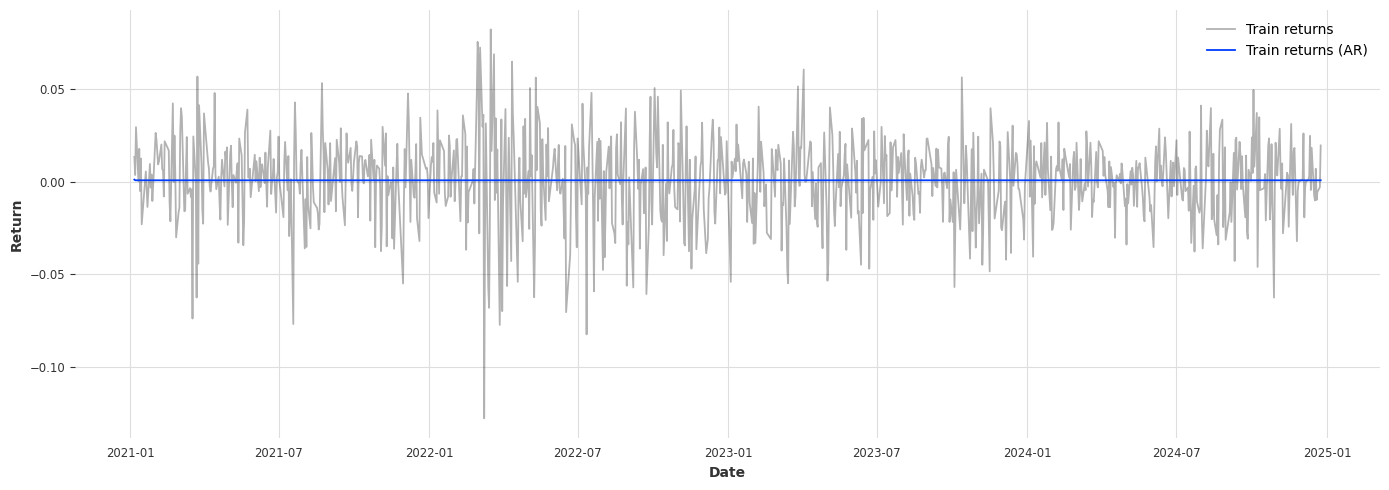

In [19]:
plt.figure(figsize=(14, 5))
sns.lineplot(x = y_train.index, y = y_train, alpha = 0.3, label = "Train returns")
sns.lineplot(x = y_train.index, y = ar_results[1]["predictions"].univariate_values(), label = "Train returns (AR)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()

### Plot Classic TCN

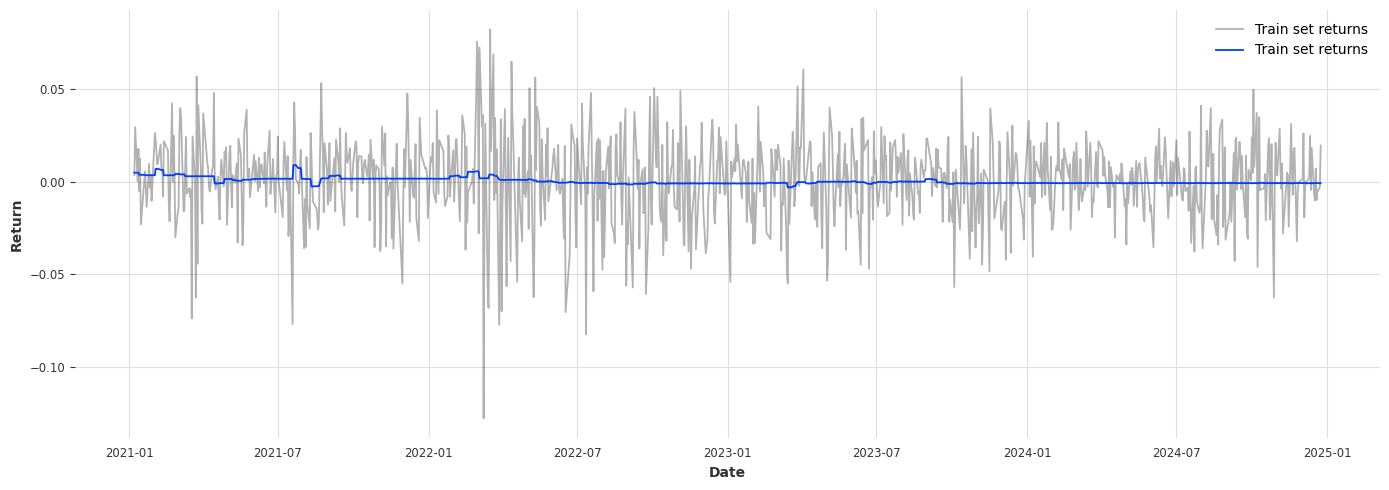

In [ ]:
plt.figure(figsize=(14, 5))
sns.lineplot(x = y_train[1:].index, y = y_train[1:], alpha = 0.3, label = "Train returns")
sns.lineplot(x = y_train[1:].index, y = predictions_class_np, label = "Train returns (TCN)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()

### Plot Hybrid Additive AR(1)-TCN

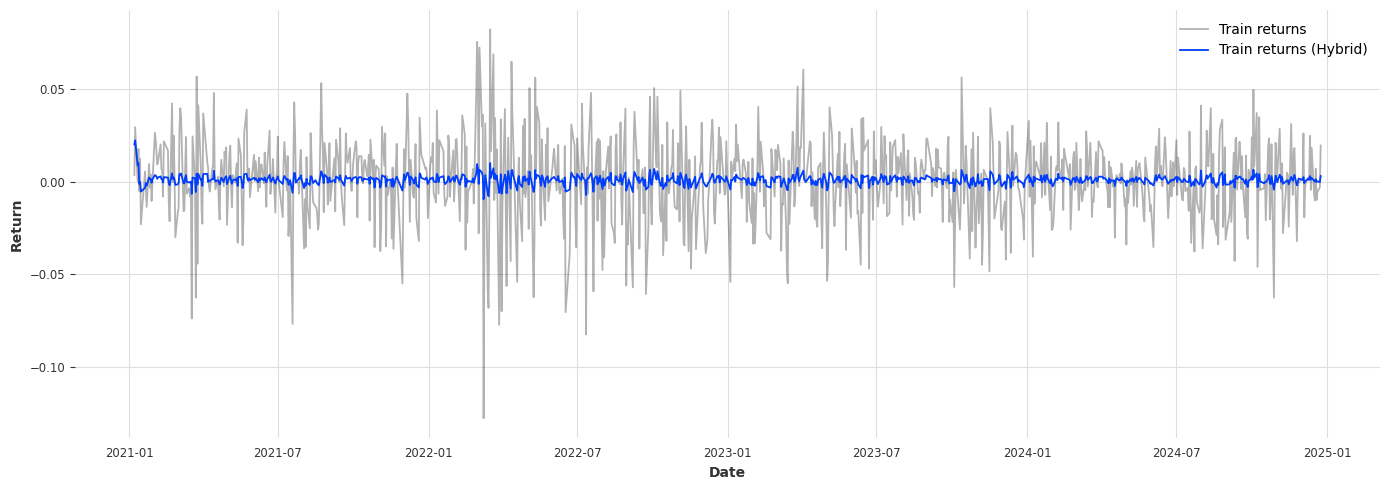

In [20]:
plt.figure(figsize=(14, 5))
sns.lineplot(x = y_train[1:].index, y = y_train[1:], alpha = 0.3, label = "Train returns")
sns.lineplot(x = y_train[1:].index, y = predictions_add1_np, label = "Train returns (Hybrid)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()

### Plot Hybrid Additive AR(5)-TCN

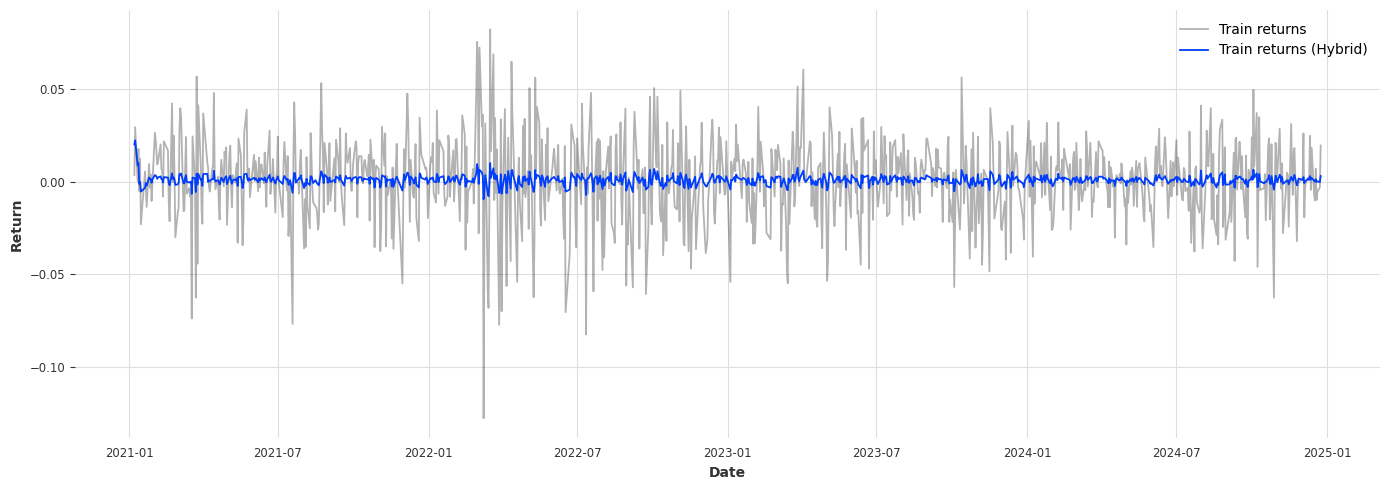

In [21]:
plt.figure(figsize=(14, 5))
sns.lineplot(x = y_train[1:].index, y = y_train[1:], alpha = 0.3, label = "Train returns")
sns.lineplot(x = y_train[1:].index, y = predictions_add5_np, label = "Train returns (Hybrid)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()